In [25]:
import datetime as dt
import difflib
import json
import math
import os
import string
import sys
from datetime import timedelta
from random import sample
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pyreadstat
import seaborn as sns
import statsmodels.tools.tools as sm
import statsmodels.base as sb
from folium.features import CustomIcon
from folium.plugins import FastMarkerCluster, HeatMap, MarkerCluster
from linearmodels.panel.model import PooledOLS
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import aic, rmse
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from yahoofinancials import YahooFinancials
import pickle

In [26]:
# year = list(range(2001, 2021))
# DataFrameDict_HILDAp = {elem: pd.DataFrame for elem in year}
# for key in DataFrameDict_HILDAp.keys():
#     order = key - 2001
#     ini = string.ascii_lowercase[order]
# #   df, meta = pyreadstat.read_dta(f"Household_{ini}200u.dta")
# #   df, meta = pyreadstat.read_dta(f"Eperson_{ini}200u.dta")
# #   df, meta = pyreadstat.read_dta(f"Rperson_{ini}200u.dta")
#     df, meta = pyreadstat.read_dta(f"Combined_{ini}200u.dta")
#     df.columns = df.columns.str[1:]
#     DataFrameDict_HILDAp[key] = df
# count_dict = dict()
# for key in DataFrameDict_HILDAp.keys():
#     for item in DataFrameDict_HILDAp[key]["waveid"].unique():
#         if item in count_dict:
#             count_dict[item] += 1
#         else:
#             count_dict[item] = 1
# count_dict.items()
# count_dict = dict()
# for key in DataFrameDict_HILDAp.keys():
#     for item in DataFrameDict_HILDAp[key]["waveid"].unique():
#         if item in count_dict:
#             count_dict[item] = key 
# count_dict.items()
# # Use a for loop to iterate over the items in the dictionary
# for key, df in DataFrameDict_HILDAp.items():
#     # Get a list of all column names
#     columns = df.columns
    
#     # Use a list comprehension to filter column names that contain the word "death"
#     death_columns = [col for col in columns if 'death' in col]
    
#     print(f"Death columns in {key}: {death_columns}")

# # Output:
# # Death columns in df1: ['deaths']
# # Death columns in df2: ['death_rate']
# DataFrameDict_waveid = {}
# for item in count_dict.keys():
#     arr_id = np.zeros(shape=(20,3))
#     for key in DataFrameDict_HILDAp.keys():
#         if sum(DataFrameDict_HILDAp[key]["waveid"] == item) != 0:
#             df = DataFrameDict_HILDAp[key][DataFrameDict_HILDAp[key]["waveid"] == item]
#             tpd = {
#                     "date" : key,
#                     "postcode": df["hhpcode"],
#                     "age": df["hgage"]
#                     }
#             tparr =  pd.DataFrame(tpd).values[0]
#             arr_id[key-2001] =  tparr
#         else: 
#             tpd = {
#                 "date" : key,
#                 "postcode": 0,
#                 "age": 0
#                   }   
#             tparr = list(tpd.values())
#             arr_id[key-2001] =  tparr
# item = '0113155'
# arr_id = np.zeros(shape=(20,3))
# for key in DataFrameDict_HILDAp.keys():
#     if sum(DataFrameDict_HILDAp[key]["waveid"] == item) != 0:
#         df = DataFrameDict_HILDAp[key][DataFrameDict_HILDAp[key]["waveid"] == item]
#         tpd = {
#                     "date" : key,
#                     "postcode": df["hhpcode"],
#                     "age": df["hgage"]
#                 }
#         tparr =  pd.DataFrame(tpd).values[0]
#         arr_id[key-2001] =  tparr
#     else: 
#         tpd = {"date" : key,"postcode": 0,"age": 0}   
#         tparr = list(tpd.values())
#         arr_id[key-2001] =  tparr

In [27]:
import pandas as pd
file_path = "expectancy_SA4.xlsx"
sheet_name = "Table_2.1"
df1 = pd.read_excel(file_path, sheet_name=sheet_name,skiprows=7, skipfooter=3)
df1 = df1.loc[:, ~df1.columns.str.contains('Unnamed')]
df1 = df1.dropna()
prefixes = ['M', 'F', 'P']
years = [f"{str(i).zfill(2)}" for i in range(17, 22)]
# Define the new column names
new_columns = [prefix + year for prefix in prefixes for year in years]
# Rename columns from the third column (index 2)
df1.rename(columns=dict(zip(df1.columns[2:], new_columns)), inplace=True)
file_path = "Expectancy_SA4_2011-2016.xlsx"
sheet_name = "Table_2.1"
df2 = pd.read_excel(file_path, sheet_name=sheet_name,skiprows=7, skipfooter=3)
df2 = df2.loc[:, ~df2.columns.str.contains('Unnamed')]
df2 = df2.dropna()
prefixes = ['M', 'F', 'P']
years = [f"{str(i).zfill(2)}" for i in range(11, 17)]
# Define the new column names
new_columns = [prefix + year for prefix in prefixes for year in years]
# Rename columns from the third column (index 2)
df2.rename(columns=dict(zip(df2.columns[2:], new_columns)), inplace=True)

In [28]:
df = pd.merge( df2,df1,on='ASGS', how='outer')
df = df.loc[:,~df.columns.duplicated()]
df.rename(columns=lambda x: x.rstrip('_suffix'), inplace=True)

In [29]:
LifeExpectancy_Male = df[['ASGS', 'GCCSA, SA4'] + [col for col in df.columns if 'M' in col]]
LifeExpectancy_Female =df[['ASGS', 'GCCSA, SA4'] + [col for col in df.columns if 'F' in col]]
LifeExpectancy_Person = df[['ASGS', 'GCCSA, SA4'] + [col for col in df.columns if 'P' in col]]


In [30]:
LifeExpectancy_Female

,ASGS,"GCCSA, SA4",F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21
0,102,Central Coast,78.6,82.7,80.6,78.6,82.8,80.6,81.4,79.2,83.6,81.4,79.1
1,115,Sydney - Baulkham Hills and Hawkesbury,83.3,86.8,85.0,83.7,86.9,85.2,86.0,84.6,87.7,86.1,85.0
2,116,Sydney - Blacktown,79.5,83.6,81.5,79.7,83.7,81.7,82.7,81.2,84.6,82.8,81.7
3,117,Sydney - City and Inner South,79.1,84.7,81.8,79.3,84.6,81.9,83.7,81.3,86.3,83.7,81.7
4,118,Sydney - Eastern Suburbs,82.7,85.7,84.2,82.9,85.8,84.3,85.1,83.7,86.9,85.3,84.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,701,Darwin,78.4,83.5,80.9,78.8,83.4,81.1,82.5,80.1,84.5,82.2,80.2
98,7GDAR,Greater Darwin,78.4,83.5,80.9,78.8,83.4,81.1,82.5,80.1,84.5,82.2,80.2
99,702,Northern Territory - Outback,71.7,75.4,73.5,72.5,75.3,73.9,74.5,72.2,76.6,74.3,73.0
100,7RNTE,Rest of NT,71.7,75.4,73.5,72.5,75.3,73.9,74.5,72.2,76.6,74.3,73.0


In [31]:
import pandas as pd

# Create an empty dictionary to store the DataFrames
dict_of_LifetablesNational = {}

# Loop through the Excel files from 2011 to 2021
for year in range(2011, 2022):
    file_name = f"LT{year}.xlsx"
    sheet_name = "Table_1.9"
    df = pd.read_excel(file_name, sheet_name,skiprows=5,skipfooter=3)
    df = df.drop(df.index[0])
    new_columns = ['age', 'lx_male', 'qx_male', 'Lx_male', 'ex_male', 'lx_female', 'qx_female', 'Lx_female', 'ex_female']
    # Rename the columns
    df.columns = new_columns
    dict_of_LifetablesNational[year] = df.reset_index(drop= True)

    # Get the 'age' column of the last dataframe
last_df = list(dict_of_LifetablesNational.values())[-1]
age_column = last_df['age']

# Update all dataframes in the dictionary with the 'age' column from the last dataframe
for key, df in dict_of_LifetablesNational.items():
    dict_of_LifetablesNational[key]['age'] = age_column

In [32]:
# Create a new dictionary with updated range keys
new_dict = {}
for i, key in enumerate(dict_of_LifetablesNational.keys()):
    new_key = str(key - 2) + '-' + str(key)
    new_dict[new_key] = dict_of_LifetablesNational[key]

# Assign the new dictionary to the variable name
dict_of_LifetablesNational_new = new_dict
# Print the updated dictionary
print(dict_of_LifetablesNational_new)


{'2009-2011':      age lx_male  qx_male Lx_male ex_male lx_female qx_female Lx_female  \
0      0  100000  0.00496   99555    79.7    100000   0.00353     99685   
1      1   99504   0.0004   99481    79.1     99647   0.00031     99630   
2      2   99463  0.00019   99453    78.2     99616   0.00016     99608   
3      3   99444  0.00015   99437    77.2     99601   0.00013     99594   
4      4   99430  0.00013   99423    76.2     99588   0.00011     99582   
..   ...     ...      ...     ...     ...       ...       ...       ...   
96    96    6281  0.24484    5483     3.2     12098   0.23072     10661   
97    97    4743  0.25623    4111       3      9307   0.24642      8120   
98    98    3528  0.26755    3035     2.9      7014    0.2604      6064   
99    99    2584  0.27815    2208     2.8      5187   0.27399      4445   
100  100    1865  0.29089    4985     2.7      3766   0.28585     10313   

    ex_female  
0        84.2  
1        83.5  
2        82.5  
3        81.5  
4    

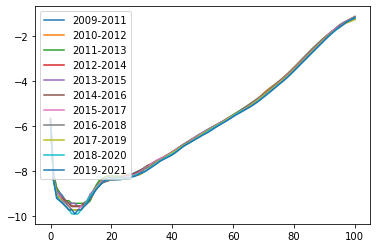

In [33]:
import matplotlib.pyplot as plt

# Plot the graphs
for key, df in dict_of_LifetablesNational_new.items():
    plt.plot(df["age"],np.log(df["qx_female"].astype('float64')), label=key)

# Add a legend and show the plot
plt.legend()
plt.show()

In [34]:
def log_function(a, t):
    return -0.332 * a + 0.332 * a * np.cos(np.exp(2.995 - a/t))**2

index = range(50, 101)
columns = range(2023, 2059)

df = pd.DataFrame(index=index, columns=columns)

for i in index:
    for j in columns:
        df.at[i, j] =np.exp(log_function(i, j))

df.to_csv('df_mt.csv', index= True)

In [35]:
# Concatenate the 'qx_female' columns of each DataFrame into a new DataFrame
result_df = pd.concat([np.log(df['qx_female'].astype('float64')) for df in dict_of_LifetablesNational.values()], axis=1, keys=dict_of_LifetablesNational.keys())

# Set the index of the new DataFrame to 'age'
result_df.index = dict_of_LifetablesNational[2011]['age']

diff_df =result_df.diff(axis=1).drop(result_df.columns[0], axis=1)

In [36]:
result_df

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
age,,,,,,,,,,,
0,-5.646457,-5.678115,-5.704783,-5.713833,-5.701784,-5.713833,-5.792614,-5.799193,-5.819193,-5.819193,-5.853443
1,-8.078938,-8.145630,-8.254829,-8.421883,-8.377431,-8.421883,-8.421883,-8.377431,-8.334872,-8.421883,-8.421883
2,-8.740337,-8.740337,-8.740337,-8.947976,-8.873868,-8.947976,-8.947976,-9.028019,-9.028019,-9.115030,-9.210340
3,-8.947976,-9.028019,-9.028019,-9.115030,-9.028019,-9.115030,-9.115030,-9.210340,-9.210340,-9.315701,-9.315701
4,-9.115030,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.315701,-9.315701,-9.433484,-9.433484,-9.433484
...,...,...,...,...,...,...,...,...,...,...,...
96,-1.466550,-1.476701,-1.407886,-1.438177,-1.426200,-1.438177,-1.449916,-1.487884,-1.501256,-1.497137,-1.498120
97,-1.400718,-1.384097,-1.345306,-1.352550,-1.352086,-1.352550,-1.370697,-1.407314,-1.432380,-1.390061,-1.395658
98,-1.345536,-1.328327,-1.286377,-1.274932,-1.287644,-1.274932,-1.295102,-1.311632,-1.375315,-1.312004,-1.321443


In [37]:
result_df0 = pd.concat([np.log(df['qx_female'].astype('float64')) for df in dict_of_LifetablesNational_new.values()], axis=1, keys=dict_of_LifetablesNational_new.keys())

# Set the index of the new DataFrame to 'age'
result_df0.index = dict_of_LifetablesNational_new['2009-2011']['age']

diff_df0 =result_df0.diff(axis=1).drop(result_df0.columns[0], axis=1)

In [38]:
conda create -n PhySO python=3.8

Remove existing environment (y/[n])? ^C

CondaSystemExit: 
Operation aborted.  Exiting.


Note: you may need to restart the kernel to use updated packages.


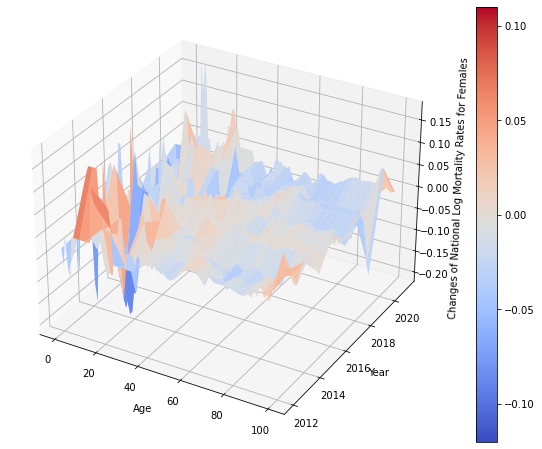

In [39]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and axes object
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid from the index and columns
Y,X = np.meshgrid(np.array(diff_df.columns), diff_df.index)
Z = diff_df.values

# Plot the 3D surface
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',vmin=-0.12, vmax=0.11)

# Set the x and y axis labels
ax.set_ylabel('Year')
ax.set_xlabel('Age')
ax.set_zlabel('Changes of National Log Mortality Rates for Females')

# Add a colorbar to the plot
fig.colorbar(surf)

# Show the plot
plt.show()

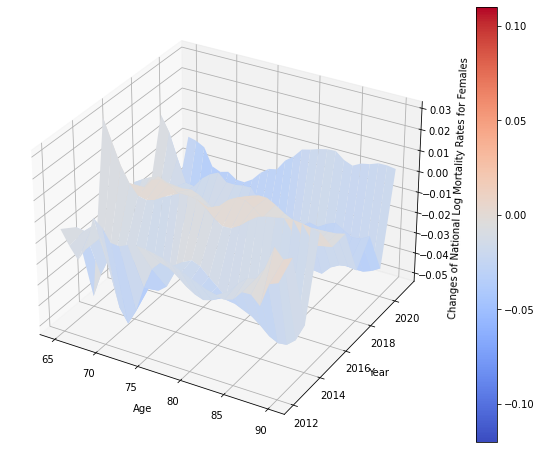

In [40]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid from the index and columns
Y,X = np.meshgrid(np.array(diff_df.columns), diff_df.loc[65:90].index)
Z = diff_df.loc[65:90].values

# Plot the 3D surface
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',vmin=-0.12, vmax=0.11)

# Set the x and y axis labels
ax.set_ylabel('Year')
ax.set_xlabel('Age')
ax.set_zlabel('Changes of National Log Mortality Rates for Females')

# Add a colorbar to the plot
fig.colorbar(surf)

# Show the plot
plt.show()

In [41]:
diff_df    
    
file_name = 'df_hc.csv'
df_hc.to_csv(file_name, index=False)

NameError: name 'df_hc' is not defined

In [42]:
diff_df_65_89 = diff_df.loc[65:89]

df_5y = pd.DataFrame(index=pd.IntervalIndex.from_breaks(range(65, 91, 5)))

# Loop through each year and group the data by the 5-year age group index
for year in diff_df_65_89.columns:
    group = diff_df_65_89[year].groupby(pd.cut(diff_df_65_89.index, range(65, 91, 5)))
    df_5y[year] = group.mean()

# Print the new DataFrame
print(df_5y)
print(diff_df.loc[65:100])

              2012      2013      2014      2015      2016      2017  \
(65, 70] -0.006419 -0.019373 -0.027170  0.006509 -0.006509 -0.005700   
(70, 75] -0.003090 -0.030490 -0.031802  0.003176 -0.003176 -0.008497   
(75, 80] -0.005669 -0.021289 -0.020356 -0.000389  0.000389 -0.005033   
(80, 85] -0.012972 -0.017443 -0.033387  0.003929 -0.003929 -0.003788   
(85, 90] -0.007682  0.000720 -0.042197  0.007951 -0.007951 -0.007322   

              2018      2019      2020      2021  
(65, 70] -0.020153 -0.010428 -0.047430 -0.017104  
(70, 75] -0.021758 -0.010836 -0.040654 -0.020036  
(75, 80] -0.029962 -0.019226 -0.047076 -0.004825  
(80, 85] -0.035723 -0.021180 -0.039805  0.001737  
(85, 90] -0.031265 -0.019634 -0.043746  0.002313  
         2012      2013      2014      2015      2016      2017      2018  \
age                                                                         
65  -0.004736 -0.009539 -0.049110  0.031382 -0.031382 -0.010118 -0.024015   
66  -0.011528 -0.010197 -0.037

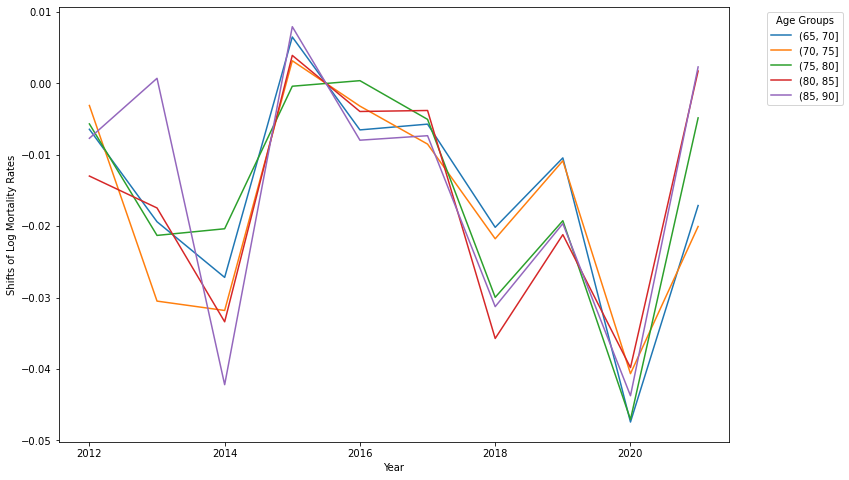

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through each age group and plot the data
for age in df_5y.index:
    y = df_5y.loc[age].values
    x = df_5y.columns
    ax.plot(x, y, label=age)

# Set the x and y axis labels and legend
ax.set_xlabel('Year')
ax.set_ylabel('Shifts of Log Mortality Rates')
ax.legend(title='Age Groups', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [44]:
diff_df_65_99 = diff_df.loc[65:99]

df_5y = pd.DataFrame(index=pd.IntervalIndex.from_breaks(range(65, 101, 5)))

# Loop through each year and group the data by the 5-year age group index
for year in diff_df_65_99.columns:
    group = diff_df_65_99[year].groupby(pd.cut(diff_df_65_99.index, range(65, 101, 5)))
    df_5y[year] = group.mean()

# Print the new DataFrame
print(df_5y)

               2012      2013      2014      2015      2016      2017  \
(65, 70]  -0.006419 -0.019373 -0.027170  0.006509 -0.006509 -0.005700   
(70, 75]  -0.003090 -0.030490 -0.031802  0.003176 -0.003176 -0.008497   
(75, 80]  -0.005669 -0.021289 -0.020356 -0.000389  0.000389 -0.005033   
(80, 85]  -0.012972 -0.017443 -0.033387  0.003929 -0.003929 -0.003788   
(85, 90]  -0.006036  0.001803 -0.040017  0.007635 -0.007635 -0.007026   
(90, 95]   0.004817  0.014992 -0.017835  0.010150 -0.010150 -0.001532   
(95, 100]  0.012467  0.046818 -0.000418 -0.005634  0.005634 -0.014442   

               2018      2019      2020      2021  
(65, 70]  -0.020153 -0.010428 -0.047430 -0.017104  
(70, 75]  -0.021758 -0.010836 -0.040654 -0.020036  
(75, 80]  -0.029962 -0.019226 -0.047076 -0.004825  
(80, 85]  -0.035723 -0.021180 -0.039805  0.001737  
(85, 90]  -0.030858 -0.019411 -0.043024  0.002401  
(90, 95]  -0.047030 -0.009131 -0.022311  0.017307  
(95, 100] -0.020566 -0.053663  0.045595 -0.005870  

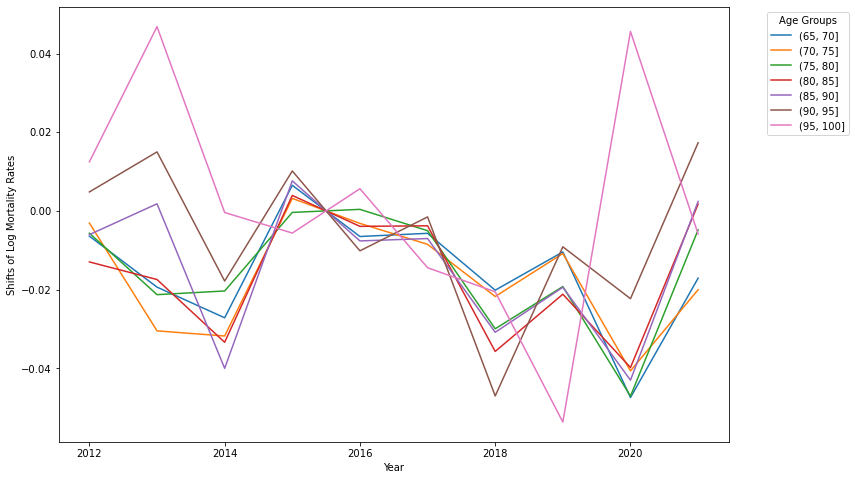

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through each age group and plot the data
for age in df_5y.index:
    y = df_5y.loc[age].values
    x = df_5y.columns
    ax.plot(x, y, label=age)

# Set the x and y axis labels and legend
ax.set_xlabel('Year')
ax.set_ylabel('Shifts of Log Mortality Rates')
ax.legend(title='Age Groups', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [46]:
# Calculate the average log qx_female for all dataframes
avg_qx_female = np.mean([np.log(df['qx_female'].astype('float64')) for df in dict_of_LifetablesNational.values()], axis=0)

# Create a new DataFrame with the columns 'year', 'partial_shift_from_avg', and 'ex_100'
new_df = pd.DataFrame(columns=['year', 'partial_shift_from_avg', 'ex_90', 'ex_95', 'ex_100'])

# Loop through each year in the dictionary
for year in dict_of_LifetablesNational.keys():
    # Get the DataFrame for the current year
    df = dict_of_LifetablesNational[year]
    
    # Calculate the partial shift from average
    shift = np.mean((np.log(df['qx_female'].astype('float64')) - avg_qx_female).loc[65:90]) 
    
    # Extract the 'ex_female' value for age 100
    ex_90 = df.loc[90, 'ex_female']
    ex_95 = df.loc[95, 'ex_female']
    ex_100 = df.loc[100, 'ex_female']
    
    # Add a new row to the DataFrame with the year, partial shift from average, and ex_100
    new_df = new_df.append({'year': pd.to_datetime(str(year)), 'partial_shift_from_avg': shift, 'ex_90': ex_90,
                           'ex_95': ex_95,'ex_100': ex_100}, ignore_index=True)

# Print the new DataFrame 

# a new name 

psfa_df = new_df.copy()
print(psfa_df)

         year  partial_shift_from_avg    ex_90    ex_95   ex_100
0  2011-01-01                0.067877  4.90000  3.50000  2.70000
1  2012-01-01                0.061121  4.90000  3.40000  2.50000
2  2013-01-01                0.044063  4.80000  3.30000  2.50000
3  2014-01-01                0.012802  4.90000  3.30000  2.30000
4  2015-01-01                0.018021  4.90000  3.30000  2.40000
5  2016-01-01                0.012802  4.90000  3.30000  2.30000
6  2017-01-01                0.006636  4.88374  3.30835  2.32399
7  2018-01-01               -0.020914  5.01145  3.36193  2.19424
8  2019-01-01               -0.036042  5.12831  3.56344  2.65620
9  2020-01-01               -0.079374  5.16245  3.44268  2.50630
10 2021-01-01               -0.086992  5.12246  3.41557  2.44444


/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/1481553947.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'year': pd.to_datetime(str(year)), 'partial_shift_from_avg': shift, 'ex_90': ex_90,
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/1481553947.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'year': pd.to_datetime(str(year)), 'partial_shift_from_avg': shift, 'ex_90': ex_90,
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/1481553947.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'year': pd.to_datetime(str(year)), 'partial_shift_from_avg': shift, 'ex_90': ex_90,
/var/folders/s1/vpd2pr

In [47]:
avg_qx_female 

array([-5.74931286, -8.33441327, -8.93820135, -9.12992779, -9.2816896 ,
       -9.40565628, -9.52551356, -9.62938006, -9.64595475, -9.64151928,
       -9.61093089, -9.51845845, -9.36923863, -9.19650669, -8.95633176,
       -8.75380937, -8.58074783, -8.46650832, -8.39628669, -8.3528211 ,
       -8.32909073, -8.33252167, -8.32107246, -8.30250462, -8.27718729,
       -8.2566981 , -8.22165346, -8.18165008, -8.12849576, -8.06619738,
       -7.98883613, -7.90449242, -7.82388581, -7.74484704, -7.65823589,
       -7.57691818, -7.49966332, -7.42368055, -7.33772396, -7.25990339,
       -7.17588745, -7.09157869, -6.99770296, -6.90465282, -6.81707977,
       -6.73354941, -6.6543813 , -6.57187105, -6.48904713, -6.40653665,
       -6.32669894, -6.24438138, -6.16263989, -6.08217307, -6.00214923,
       -5.92604943, -5.849997  , -5.77288974, -5.69212054, -5.61110122,
       -5.52788682, -5.4458252 , -5.36639929, -5.28766904, -5.20759414,
       -5.12179339, -5.02985391, -4.93240834, -4.83195633, -4.72

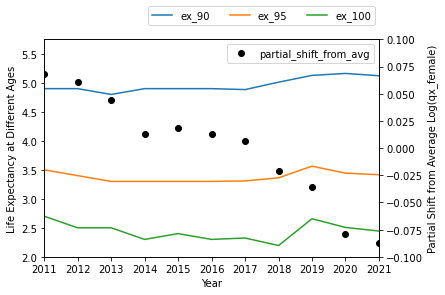

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot the 'ex_female' values for age 90, 95, and 100
ax1.plot(new_df['year'], new_df['ex_90'], label='ex_90')
ax1.plot(new_df['year'], new_df['ex_95'], label='ex_95')
ax1.plot(new_df['year'], new_df['ex_100'], label='ex_100')

# Plot the 'partial_shift_from_avg' values as dots

ax2.plot(new_df['year'], new_df['partial_shift_from_avg'], 'o', label='partial_shift_from_avg', color = 'black')

# Set the x-axis label and limits
ax1.set_xlabel('Year')
ax1.set_xlim([new_df['year'].min(), new_df['year'].max()])

# Set the y-axis label and limits
ax1.set_ylabel('Life Expectancy at Different Ages')
ax1.set_ylim([2, 5.75])

# Set the right y-axis label and limits
ax2.set_ylabel('Partial Shift from Average Log(qx_female)')
ax2.set_ylim([-0.1, 0.1])

# Show the legend
ax1.legend(loc='upper center', bbox_to_anchor=(0.65, 1.175),ncol =3)
ax2.legend(loc='upper right')
# Show the plot
plt.show()


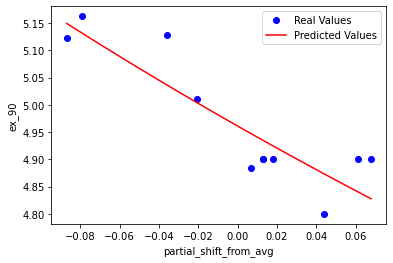

In [49]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Define the x and y data
x = psfa_df['partial_shift_from_avg']
y = psfa_df['ex_90']

# Fit the inverse Gaussian model
X = sm.add_constant(x)
model_GLM = sm.GLM(y, X, family=sm.families.InverseGaussian()).fit()

# Predict the values of ex_90 using the model
x_pred = np.linspace(x.min(), x.max(), 100)
X_pred = sm.add_constant(x_pred)
y_pred = model_GLM.predict(X_pred)

# Plot the predicted and real values of ex_90
plt.plot(x, y, 'bo', label='Real Values')
plt.plot(x_pred, y_pred, 'r-', label='Predicted Values')
plt.xlabel('partial_shift_from_avg')
plt.ylabel('ex_90')
plt.legend()
plt.show()


In [50]:
def predict_ex_90(x):
    X_pred = sm.add_constant(x_pred)
    y_pred = model_GLM.predict(X_pred)

    return y_pred[0]

In [51]:
import statsmodels.api as sm
import pandas as pd

# Create a new DataFrame with the columns 'ex_90' and 'partial_shift_from_avg'
df = psfa_df[['ex_90', 'partial_shift_from_avg']].copy()

# Fit a GLM with inverse Gaussian family
model_ig = sm.GLM(df['ex_90'], sm.add_constant(df['partial_shift_from_avg']), family=sm.families.InverseGaussian())
result_ig = model_ig.fit()

# Fit a GLM with gamma family
model_gamma = sm.GLM(df['ex_90'], sm.add_constant(df['partial_shift_from_avg']), family=sm.families.Gamma())
result_gamma = model_gamma.fit()

# Fit a GLM with Gaussian/normal family
model_gaussian = sm.GLM(df['ex_90'], sm.add_constant(df['partial_shift_from_avg']), family=sm.families.Gaussian())
result_gaussian = model_gaussian.fit()

# Calculate the LL, AIC, and BIC for each model
ll_ig = result_ig.llf
aic_ig = result_ig.aic
bic_ig = result_ig.bic

ll_gamma = result_gamma.llf
aic_gamma = result_gamma.aic
bic_gamma = result_gamma.bic

ll_gaussian = result_gaussian.llf
aic_gaussian = result_gaussian.aic
bic_gaussian = result_gaussian.bic

# Create a new DataFrame to store the information criteria
ic_df = pd.DataFrame({
    'Family': ['Inv. Gauss', 'Gamma', 'Gaussian/Normal'],
    'AIC': [aic_ig, aic_gamma, aic_gaussian],
    'BIC': [bic_ig, bic_gamma, bic_gaussian]
})

# Export the information criteria as LaTeX table
print(ic_df.to_latex(index=False))

print('Inverse Gaussian Family')
print(result_ig.summary())
print('\n')

\begin{tabular}{lrr}
\toprule
         Family &        AIC &        BIC \\
\midrule
     Inv. Gauss & -28.852047 & -21.580797 \\
          Gamma & -28.769012 & -21.579753 \\
Gaussian/Normal & -28.783019 & -21.548353 \\
\bottomrule
\end{tabular}

Inverse Gaussian Family
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  ex_90   No. Observations:                   11
Model:                            GLM   Df Residuals:                        9
Model Family:         InverseGaussian   Df Model:                            1
Link Function:        inverse_squared   Scale:                      2.9069e-05
Method:                          IRLS   Log-Likelihood:                 16.426
Date:                Wed, 05 Apr 2023   Deviance:                   0.00026071
Time:                        03:35:51   Pearson chi2:                 0.000262
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9455
Covariance Type:   

/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/leiflyu/miniforge3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1799: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/160364680.py:40: FutureWarning: In future versions `DataFrame.to

In [52]:
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# def shift_mortality(df, column, shift):
#     shifted_mortality = np.exp(np.log(df[column].astype('float64'))+shift)
#     return shifted_mortality 

# def integrate_column(df, y_column, shift, end_index):
#     x = df.loc[0: end_index,'age'].values
#     y = shift_mortality(df, y_column, shift).loc[0: end_index]
#     result = scipy.integrate.simps(y, x,  even='first')
#     return result

# def generate_column(df,y_column,shift):
#     new_df = df
#     new_df['tp1'] = new_df.apply(lambda row: integrate_column(df,y_column,shift,row['age']), axis=1)
#     new_df['tp2'] = np.exp(-new_df['tp1'])
#     new_df.loc[len(df)-1, 'tp3'] = 2.6562 
#     for i in range(0,len(df)-1,1):
#         new_df.loc[i, 'tp3'] = new_df.loc[len(df)-1, 'tp3']+ scipy.integrate.simps(new_df.loc[i:len(df) , 'tp2'], new_df.loc[i:len(df), 'age'],even='first')
#     return new_df

In [53]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def add_suffix(string1, string2):
    suffix = string1.split("_")[-1]
    return string2 + "_" + suffix

def shift_mortality(df, column, shift):
    shifted_mortality = np.exp(np.log(df[column].astype('float64'))+shift)
    return shifted_mortality 

def generate_column(df,y_column,shift):
    new_df = pd.DataFrame({})
    new_df['shifted_qx'] = shift_mortality(df, y_column, shift)
    new_df['survive_p'] =  1 - new_df['shifted_qx']
    new_df['survive_cum'] =  new_df['survive_p'].cumprod() 
    new_df.loc[len(df) - 1, 'life_expectancy'] = df.loc[len(df) - 1,add_suffix(y_column,'ex')]
    for i in range(len(df) - 2, -1, -1):
        new_df.loc[i, 'life_expectancy'] =  new_df.loc[i,'survive_p']*(new_df.loc[i+1,'life_expectancy']+1) + 0.50*new_df.loc[i,'shifted_qx']
    return new_df

def shift2LEatBirth(df,y_column,shift):
    LE0 = generate_column(df,y_column,shift).loc[0,'life_expectancy']
    return LE0    

In [54]:
def shift2LEatBirth_new(shift):
    df = pd.DataFrame({})
    df['shifted_qx'] = np.exp(avg_qx_female + shift)  
    df['survive_p'] =  1 - df['shifted_qx']
    df['survive_cum'] =  df['survive_p'].cumprod() 
    df = df.loc[0:89]
    df.loc[len(df) - 1, 'life_expectancy'] = predict_ex_90(shift)
    for i in range(len(df) - 2, -1, -1):
        df.loc[i, 'life_expectancy'] =  df.loc[i,'survive_p']*(df.loc[i+1,'life_expectancy']+1) + 0.5* df.loc[i,'shifted_qx']
    return df.loc[0,'life_expectancy']
        
        
    


In [55]:
# create an empty DataFrame to store the results
df_results  = pd.DataFrame({}, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
# loop through the new_df DataFrame and call the shift2LEatBirth function
for i, row in psfa_df.iterrows():
    key = row['year'].year
    shift = row['partial_shift_from_avg']
    df = dict_of_LifetablesNational[key]
    data = [[key,shift,df['ex_female'].loc[0], shift2LEatBirth(df, 'qx_female', shift)]]
    newdf = pd.DataFrame(data, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
    df_results =  pd.concat([df_results , newdf], ignore_index=True)

    
#     df_results = df_results.append(pd.Series(new_row, index=df_results.columns), ignore_index=True)


In [56]:
df_results 

,Year,Partial Shift from Avg,real_ex_0,predicted_ex_0
0,2011,0.067877,84.20000,83.558223
1,2012,0.061121,84.30000,83.674775
2,2013,0.044063,84.30000,83.911803
3,2014,0.012802,84.60000,84.442417
4,2015,0.018021,84.50000,84.337617
5,2016,0.012802,84.60000,84.442417
6,2017,0.006636,84.62698,84.565107
7,2018,-0.020914,84.87291,85.065609
8,2019,-0.036042,85.04050,85.375885
9,2020,-0.079374,85.34462,86.074813


In [57]:
# create an empty DataFrame to store the results
df_result_new  = pd.DataFrame({}, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
# loop through the new_df DataFrame and call the shift2LEatBirth function
for i, row in psfa_df.iterrows():
    key = row['year'].year
    shift = row['partial_shift_from_avg']
    df = dict_of_LifetablesNational[key]
    data = [[key,shift,df['ex_female'].loc[0], shift2LEatBirth_new(shift)]]
    newrow = pd.DataFrame(data, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
    df_result_new =  pd.concat([df_result_new, newrow], ignore_index=True)


In [58]:
df_result_new 
# Choose this one 

,Year,Partial Shift from Avg,real_ex_0,predicted_ex_0
0,2011,0.067877,84.20000,84.078469
1,2012,0.061121,84.30000,84.131555
2,2013,0.044063,84.30000,84.264699
3,2014,0.012802,84.60000,84.505408
4,2015,0.018021,84.50000,84.465522
5,2016,0.012802,84.60000,84.505408
6,2017,0.006636,84.62698,84.552390
7,2018,-0.020914,84.87291,84.760243
8,2019,-0.036042,85.04050,84.872970
9,2020,-0.079374,85.34462,85.190321


In [59]:
def sigmoid(x, para):
    return 1 / (1 + np.exp(-para[0] * x)) - para[1]


def shift2LEatBirth_partial(df,y_column,shift,para = np.array([1, 0])):
    df = pd.DataFrame({})
    adjusted_shift_arr = np.zeros((101,))
    adjusted_shift_arr[0:66] = (sigmoid(np.linspace(-10, 10, 66), para))* shift
    adjusted_shift_arr[66:101] = shift
    df['shifted_qx'] = np.exp(avg_qx_female + adjusted_shift_arr)
    df['survive_p'] =  1 - df['shifted_qx']
    df['survive_cum'] =  df['survive_p'].cumprod() 
    df = df.loc[0:89]
    df.loc[len(df) - 1, 'life_expectancy'] = predict_ex_90(shift)
    for i in range(len(df) - 2, -1, -1):
        df.loc[i, 'life_expectancy'] =  df.loc[i,'survive_p']*(df.loc[i+1,'life_expectancy']+1) + 0.50*df.loc[i,'shifted_qx']
    return df.loc[0,'life_expectancy']
        
        

In [60]:
# create an empty DataFrame to store the results
df_result_p  = pd.DataFrame({}, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
# loop through the new_df DataFrame and call the shift2LEatBirth function
for i, row in psfa_df.iterrows():
    key = row['year'].year
    shift = row['partial_shift_from_avg']
    df = dict_of_LifetablesNational[key]
    data = [[key,shift,df['ex_female'].loc[0], shift2LEatBirth_partial(df, 'qx_female', shift)]]
    df = pd.DataFrame(data, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
    df_result_p =  pd.concat([df_result_p , df], ignore_index=True)

In [61]:
from sklearn.metrics import mean_squared_error
def sigmoid_tuning(para):
    df_result_p  = pd.DataFrame({}, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
# loop through the new_df DataFrame and call the shift2LEatBirth function
    for i, row in psfa_df.iterrows():
        key = row['year'].year
        shift = row['partial_shift_from_avg']
        df = dict_of_LifetablesNational[key]
        data = [[key,shift,df['ex_female'].loc[0], shift2LEatBirth_partial(df, 'qx_female', shift, para)]]
        df = pd.DataFrame(data, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
        df_result_p =  pd.concat([df_result_p , df], ignore_index=True)
    mse = mean_squared_error(df_result_p['real_ex_0'], df_result_p['predicted_ex_0'])
    return mse    

        

In [62]:
import scipy
x0 = np.array([1, 0])

# Use the Nelder-Mead algorithm to minimize the tuning function
res = scipy.optimize.minimize(sigmoid_tuning,x0,method='nelder-mead')

# Print the optimal values of a and b
print('Optimal a, b:', res.x)

/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/2283136391.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-para[0] * x)) - para[1]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/2283136391.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-para[0] * x)) - para[1]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/2283136391.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-para[0] * x)) - para[1]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/2283136391.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-para[0] * x)) - para[1]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/2283136391.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-para[0] * x)) - para[1]
/var/folders/s1/vpd2prqd5fsc16qqsymrc9b00000gn/T/ipykernel_15440/2283136391.py:2: RuntimeWarning: overflow encountered i

Optimal a, b: [ 0.04418873 -0.57950817]


In [63]:
res.x

array([ 0.04418873, -0.57950817])

In [64]:
# create an empty DataFrame to store the results
df_result_p  = pd.DataFrame({}, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])

# loop through the new_df DataFrame and call the shift2LEatBirth function
for i, row in psfa_df.iterrows():
    key = row['year'].year
    shift = row['partial_shift_from_avg']
    df = dict_of_LifetablesNational[key]
    data = [[key,shift,df['ex_female'].loc[0], shift2LEatBirth_partial(df, 'qx_female', shift, res.x)]]
    df = pd.DataFrame(data, columns=['Year', 'Partial Shift from Avg', 'real_ex_0','predicted_ex_0'])
    df_result_p =  pd.concat([df_result_p , df], ignore_index=True)

df_result_p 

,Year,Partial Shift from Avg,real_ex_0,predicted_ex_0
0,2011,0.067877,84.20000,84.055553
1,2012,0.061121,84.30000,84.111034
2,2013,0.044063,84.30000,84.250111
3,2014,0.012802,84.60000,84.501277
4,2015,0.018021,84.50000,84.459682
5,2016,0.012802,84.60000,84.501277
6,2017,0.006636,84.62698,84.550260
7,2018,-0.020914,84.87291,84.766804
8,2019,-0.036042,85.04050,84.884134
9,2020,-0.079374,85.34462,85.214025


In [65]:
# def closest_input(df, year):
#     last_two_digits = str(year % 100).zfill(2)
#     column = 'F' + last_two_digits
#     inputs = np.arange(-1, 1, 0.01)
#     results = [shift2LEatBirth(dict_of_LifetablesNational[year],"qx_female",x) for x in inputs]
#     closest_inputs = []
#     for value in df[column]:
#         diff = np.abs(np.asarray(results) - value)
#         closest_index = np.argmin(diff)
#         closest_inputs.append(inputs[closest_index])
#     new_column = column + '_shift'
#     df[new_column] = closest_inputs
#     return df

# for year in range(2011,2022):
#     closest_input(LifeExpectancy_Female,year)

In [66]:
psfa_df_ind = psfa_df.set_index('year', inplace=False).copy()
psfa_df_ind.index = psfa_df_ind.index.strftime('%Y')

def shift2LE_Final(year,shift0):
    key = year     
        # Use loc to select the row corresponding to the given year
    row = psfa_df_ind.loc[str(year)]
        # Extract the value of 'Partial Shift from Avg'
    partial_shift = row[0]
    shift = shift0 + partial_shift
    results = shift2LEatBirth_partial(df, 'qx_female', shift, res.x) 
    return results   

        

In [67]:
years = range(2011, 2022)

# Define the range of shift0 values to include in the dataframe
shift0_values = pd.Series(data=np.arange(-1, 1.01, 0.01), name='shift0')

# Create an empty dataframe with the years as the index and the shift0 values as the columns
df = pd.DataFrame(columns=years, index=shift0_values)

# Fill in the dataframe with the values from the shift2LE_Final function
for year in years:
    for shift0 in shift0_values:
        df.at[shift0,year] = shift2LE_Final(year, shift0)
        print(shift2LE_Final(year, shift0))    
print(df)        

89.9896266289023
89.95029902618555
89.9106342244073
89.87063000886411
89.83028416363435
89.78959447188394
89.74855871617872
89.70717467880345
89.66544014208593
89.62335288872885
89.58091070214745
89.53811136681415
89.49495266860868
89.4514323951762
89.40754833629065
89.36329828422579
89.31868003413219
89.27369138442114
89.22833013715564
89.18259409844691
89.13648107885899
89.0899888938198
89.04311536403756
88.99585831592589
88.94821558203478
88.9001850014879
88.85176442042722
88.80295169246453
88.75374467913879
88.70414125038135
88.65413928498681
88.6037366710913
88.55293130665684
88.50172109996252
88.45010397010238
88.3980778474895
88.34564067436696
88.2927904053242
88.23952500782141
88.18584246271888
88.13174076481249
88.07721792337621
88.02227196271022
87.96690092269452
87.91110285934943
87.85487584540091
87.79821797085194
87.74112734355921
87.683602089816
87.62564035493922
87.56724030386198
87.50840012173214
87.4491180145144
87.38939220959713
87.32922095640522
87.26860252701569
87.

86.85599814932334
86.79191869375154
86.72737820068843
86.66237519230361
86.59690822017909
86.53097586596095
86.46457674201123
86.39770949206302
86.33037279187462
86.2625653498848
86.19428590786828
86.12553324159133
86.05630616146644
85.98660351320599
85.9164241784756
85.84576707554498
85.77463115993683
85.70301542507434
85.63091890292445
85.558340664639
85.48527982119202
85.41173552401264
85.33770696561325
85.26319338021403
85.18819404435983
85.1127082775331
85.03673544275948
84.96027494720599
84.88332624277317
84.80588882667737
84.72796224202655
84.64954607838487
84.57063997232973
84.49124360799712
84.41135671761711
84.33097908203712
84.25011053123436
84.16875094481527
84.08690025250088
84.00455843460051
83.9217255224689
83.83840159895007
83.75458679880428
83.67028130911967
83.58548536970625
83.50019927347293
83.41442336678584
83.32815804980784
83.24140377681898
83.15416105651568
83.0664304522902
82.97821258248753
82.88950812064058
82.8003177956823
82.71064239213415
82.62048275027006


KeyboardInterrupt: 

In [ ]:
refer_df = df.copy()

In [ ]:
def closest_shift0(df, year):
    last_two_digits = str(year % 100).zfill(2)
    column = 'F' + last_two_digits
    closest_inputs = []
    for value in df[column]:
        diff = np.abs( value - refer_df[year])
        closest_index = np.argmin(diff)
        closest_inputs.append()
    new_column = column + '_shift'
    df[new_column] = closest_inputs
    return df

In [ ]:
LEwithShift_FE = LifeExpectancy_Female.copy()
for year in range(2011,2022):
     closest_input(LEwithShift_FE,year)

In [ ]:
# def closest_input(df, year):
#     last_two_digits = str(year % 100).zfill(2)
#     column = 'F' + last_two_digits
#     inputs = np.arange(-1, 1, 0.01)
#     results = [shift2LEatBirth(dict_of_LifetablesNational[year],"qx_female",x) for x in inputs]
#     closest_inputs = []
#     for value in df[column]:
#         diff = np.abs(np.asarray(results) - value)
#         closest_index = np.argmin(diff)
#         closest_inputs.append(inputs[closest_index])
#     new_column = column + '_shift'
#     df[new_column] = closest_inputs
#     return df

In [ ]:
# df_shift = LifeExpectancy_Female.filter(regex='shift$')

# # Add the 'ASGS' column to the selected columns
# df_shift['ASGS'] = LifeExpectancy_Female['ASGS']

# # Flip the dataframe
# df_flipped = df_shift.melt(id_vars='ASGS', var_name='year', value_name='value')

# # Remove the suffix '_shift' from the 'year' column
# df_flipped['time'] = df_flipped['year'].str.replace('_shift', '')

# df_flipped['time'] = df_flipped['time'].str.replace('F', '')

# # Add '20' right before the values in the 'year' column
# df_flipped['time'] = '20' + df_flipped['time']

# # Make the 'year' column a time series
# df_flipped['time'] = pd.to_datetime(df_flipped['time'], format='%Y')

# # Set the 'year' column as the index
# df_flipped.set_index('time', inplace=True)

# # Remove the column named 'yea'
# df_flipped.drop(columns=['year'], inplace=True)

# panel_data = pd.DataFrame({group: df_flipped[df_flipped['ASGS'] == group].value for group in df_flipped['ASGS'].unique()})

# pd.options.display.float_format = '{:,.2f}'.format
# # panel_data 

In [68]:
df_shift = LEwithShift_FE.filter(regex='shift$')

# Add the 'ASGS' column to the selected columns
df_shift['ASGS'] = LEwithShift_FE['ASGS']

# Flip the dataframe
df_flipped = df_shift.melt(id_vars='ASGS', var_name='year', value_name='value')

# Remove the suffix '_shift' from the 'year' column
df_flipped['time'] = df_flipped['year'].str.replace('_shift', '')

df_flipped['time'] = df_flipped['time'].str.replace('F', '')

# Add '20' right before the values in the 'year' column
df_flipped['time'] = '20' + df_flipped['time']

# Make the 'year' column a time series
df_flipped['time'] = pd.to_datetime(df_flipped['time'], format='%Y')

# Set the 'year' column as the index
df_flipped.set_index('time', inplace=True)

# Remove the column named 'yea'
df_flipped.drop(columns=['year'], inplace=True)

panel_data = pd.DataFrame({group: df_flipped[df_flipped['ASGS'] == group].value for group in df_flipped['ASGS'].unique()})

pd.options.display.float_format = '{:,.2f}'.format
 


NameError: name 'LEwithShift_FE' is not defined

In [69]:
panel_data

NameError: name 'panel_data' is not defined

In [70]:
#To find the mean, standard deviation, and coefficient of variation (CV) of a DataFrame by columns, you can use the mean(), std(), and div() methods, respectively.

#Here's an example code snippet that shows how to calculate the mean, standard deviation, and CV of a DataFrame by columns:
mean = panel_data.mean()
std = panel_data.std()
cv = std.div(mean).mul(100)


NameError: name 'panel_data' is not defined

In [71]:
cvdf = pd.DataFrame(cv)

NameError: name 'cv' is not defined

In [72]:

prop1 = ((cvdf > -100) & (cvdf < 100)).sum().sum() / (cvdf.shape[0] * cvdf.shape[1])
prop2 = ((cvdf > -200) & (cvdf < 200)).sum().sum() / (cvdf.shape[0] * cvdf.shape[1])
prop3 = ((cvdf > -300) & (cvdf < 300)).sum().sum() / (cvdf.shape[0] * cvdf.shape[1])
print('Proportion of data between -100% and 100%:', prop1)
print('Proportion of data between -200% and 200%:', prop2)
print('Proportion of data between -300% and 300%:', prop3)


# List the rows that do not satisfy the condition
rows = cvdf[~((cvdf > -100) & (cvdf < 100))].dropna(how='all')
print('Rows not satisfying the condition:')
print(rows)



NameError: name 'cvdf' is not defined

In [73]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Create a sample DataFrame with 11 rows and 102 columns
np.random.seed(0)
df = pd.DataFrame(np.random.randn(11, 102), columns=range(102))
df.index = pd.date_range(start='2010-01-01', periods=11, freq='A')

# Fit a linear regression model to each column and calculate R-squared values
r_squared_values = []
for col in df.columns:
    X = df.index.to_series().astype(int).values.reshape(-1, 1)
    y = df[col].values
    model = LinearRegression().fit(X, y)
    r_squared = model.score(X, y)
    r_squared_values.append(r_squared)

# Store the R-squared values in a new DataFrame
r_squared_df = pd.DataFrame({'Column': df.columns, 'R-squared': r_squared_values})

# Print the DataFrame
print(r_squared_df)

#This will produce a DataFrame with 102 rows and 2 columns, where each row represents a column 
#from the original DataFrame and the R-squared column contains the corresponding R-squared value. 
#A high value of R-squared indicates a strong linear relationship between the column and the time index, 
#implying a time trend.

     Column  R-squared
0         0   0.020993
1         1   0.094460
2         2   0.179459
3         3   0.178804
4         4   0.076612
..      ...        ...
97       97   0.366812
98       98   0.121053
99       99   0.014956
100     100   0.111299
101     101   0.138024

[102 rows x 2 columns]


/Users/leiflyu/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


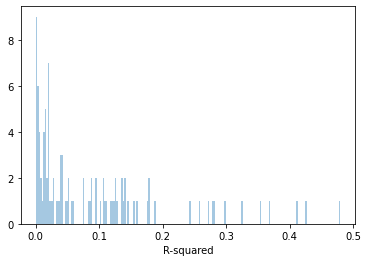

In [74]:
# Plot a distribution plot of the R-squared values
sns.distplot(r_squared_df['R-squared'], kde=False,bins=200)

# Get the top ten R-squared values and their indices
top_six = r_squared_df.nlargest(6, 'R-squared')



In [75]:
# Convert the column names from panel_data to a dictionary
column_names = {index: col for index, col in enumerate(panel_data.columns)}

# Replace the values in the 'Column' column with the corresponding column names from panel_data
top_six['Column'] =top_six['Column'].map(column_names)

top_six = top_six.reset_index(drop = True)
top_six_sa4 = top_six.rename(columns={'Column': 'ASGS'}).merge(LifeExpectancy_Female, on='ASGS')

NameError: name 'panel_data' is not defined

In [76]:
top_six_sa4

NameError: name 'top_six_sa4' is not defined

In [77]:
from PIL import Image
plot = plt.imread("exp_age.png")

In [78]:
array = np.asarray(plot)
shape = array.shape
x = 100
y = 200
pixel_value = array[y, x]
average_pixel_value = np.mean(array)



In [79]:
average_pixel_value

0.9798115

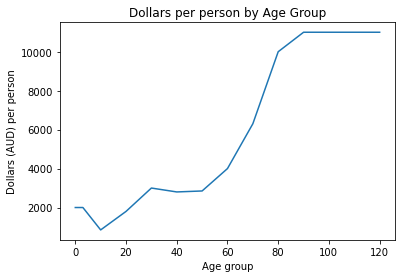

In [114]:
age_groups = [3, 10, 20, 30, 40, 50, 60, 70, 80, 90]

# Define the dollar values per person
dollar_values = [2000, 850, 1800, 3000, 2800, 2850, 4000, 6300, 10000, 11000]

# Create the DataFrame
df = pd.DataFrame({'Age group': age_groups, '2008-2009': dollar_values})

new_age_groups = np.arange(0, 121)
new_dollar_values = np.interp(new_age_groups, df['Age group'], df['2008-2009'])
new_df = pd.DataFrame({'Age group': new_age_groups, '2008-2009': new_dollar_values})

# Plot the interpolated data
plt.plot(new_df['Age group'], new_df['2008-2009'])
plt.xlabel('Age group')
plt.ylabel('Dollars (AUD) per person')
plt.title('Dollars per person by Age Group')
plt.show()

In [115]:
new_df1 = pd.DataFrame({})
new_df1['Age group'] = new_df['Age group']*92.5/90
new_df1['2021-2022'] = new_df['2008-2009']
new_df1_adapted = pd.DataFrame({})
new_df1_adapted['Age group']  = new_df['Age group']
new_df1_adapted['2021-2022'] = np.interp(new_age_groups, new_df1['Age group'], new_df1['2021-2022'])



In [116]:
new_df2 = pd.DataFrame({})
new_df2['Age group'] = new_df['Age group']*99.5/90
new_df2['2056-2057'] = new_df['2008-2009']


new_df2_adapted = pd.DataFrame({})
new_df2_adapted['Age group']  = new_df['Age group']
new_df2_adapted['2056-2057'] = np.interp(new_age_groups, new_df2['Age group'], new_df2['2056-2057'])



In [117]:
combined_df = pd.concat([new_df, new_df1_adapted, new_df2_adapted], axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df 

,Age group,2008-2009,2021-2022,2056-2057
0,0,2000.000000,2000.000000,2000.000000
1,1,2000.000000,2000.000000,2000.000000
2,2,2000.000000,2000.000000,2000.000000
3,3,2000.000000,2000.000000,2000.000000
4,4,1835.714286,1853.474903,1898.456569
...,...,...,...,...
116,116,11000.000000,11000.000000,11000.000000
117,117,11000.000000,11000.000000,11000.000000
118,118,11000.000000,11000.000000,11000.000000
119,119,11000.000000,11000.000000,11000.000000


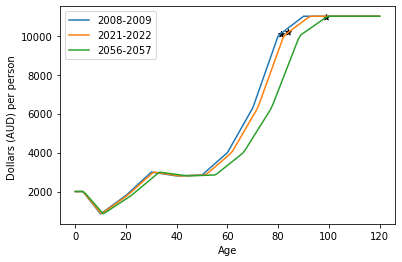

In [118]:
plt.plot(combined_df['Age group'], combined_df['2008-2009'], label='2008-2009')
plt.plot(combined_df['Age group'], combined_df['2021-2022'], label='2021-2022')
plt.plot(combined_df['Age group'], combined_df['2056-2057'], label='2056-2057')
plt.scatter([81], [10100], marker='*', color='black')
plt.scatter([84], [10172.97], marker='*', color='black')
plt.scatter([99], [10954.77], marker='*', color='black')

plt.xlabel('Age')
plt.ylabel('Dollars (AUD) per person ')

plt.legend()
plt.show()

In [119]:
combined_df_new =  combined_df.copy()
combined_df_new['2021-2022']  =combined_df_new['2021-2022']  *134/90
combined_df_new['2056-2057'] =combined_df_new['2056-2057']  *341/90

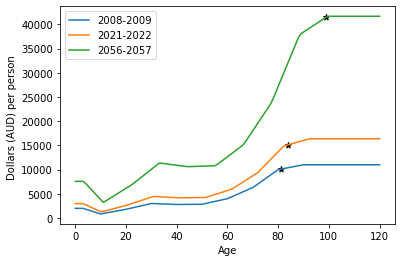

In [120]:
plt.plot(combined_df_new['Age group'], combined_df_new['2008-2009'], label='2008-2009')
plt.plot(combined_df_new['Age group'], combined_df_new['2021-2022'], label='2021-2022')
plt.plot(combined_df_new['Age group'], combined_df_new['2056-2057'], label='2056-2057')
plt.scatter([81], [10100], marker='*', color='black')
plt.scatter([84], [10172.97 *134/90], marker='*', color='black')
plt.scatter([99], [10954.77 * 341/90], marker='*', color='black')

plt.xlabel('Age')
plt.ylabel('Dollars (AUD) per person ')

plt.legend()
plt.show()

In [124]:
df_hc = pd.DataFrame({})
cpi = np.load('cpi_annual_.npy')


for Y in range(2023,2078):
    n_df = pd.DataFrame({})
    multiplier = (0.19 * (Y-2008) + 90)/90
    n_df['Age group'] = new_df['Age group'] * multiplier 
    n_df[Y] = new_df['2008-2009']
    
    n_df_adapted = pd.DataFrame({})
    n_df_adapted['Age group']  = new_df['Age group']
    n_df_adapted[Y] = np.interp(new_age_groups, n_df['Age group'], n_df[Y]) * cpi[Y-2023]
    df_hc[Y] = n_df_adapted[Y]
    
file_name = 'df_hc.csv'
df_hc.to_csv(file_name, index=False)
    

,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,...,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077
0,2092.244113,2161.960451,2208.952751,2268.076710,2332.292630,2395.375061,2459.935522,2527.402279,2596.593673,2667.184149,...,7024.521699,7216.043578,7412.787255,7614.895100,7822.513366,8035.792294,8254.886221,8479.953690,8711.157569,8948.665165
1,2092.244113,2161.960451,2208.952751,2268.076710,2332.292630,2395.375061,2459.935522,2527.402279,2596.593673,2667.184149,...,7024.521699,7216.043578,7412.787255,7614.895100,7822.513366,8035.792294,8254.886221,8479.953690,8711.157569,8948.665165
2,2092.244113,2161.960451,2208.952751,2268.076710,2332.292630,2395.375061,2459.935522,2527.402279,2596.593673,2667.184149,...,7024.521699,7216.043578,7412.787255,7614.895100,7822.513366,8035.792294,8254.886221,8479.953690,8711.157569,8948.665165
3,2092.244113,2161.960451,2208.952751,2268.076710,2332.292630,2395.375061,2459.935522,2527.402279,2596.593673,2667.184149,...,7024.521699,7216.043578,7412.787255,7614.895100,7822.513366,8035.792294,8254.886221,8479.953690,8711.157569,8948.665165
4,1941.482304,2007.581179,2052.648722,2109.052256,2170.264193,2230.496938,2292.181290,2356.651386,2422.809707,2490.355062,...,6706.993129,6893.793497,7085.779146,7283.093640,7485.884512,7694.303368,7908.506006,8128.652525,8354.907450,8587.439849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,11507.342620,11890.782483,12149.240131,12474.421904,12827.609467,13174.562838,13529.645372,13900.712535,14281.265204,14669.512821,...,38634.869344,39688.239679,40770.329900,41881.923049,43023.823514,44196.857619,45401.874214,46639.745294,47911.366628,49217.658410
117,11507.342620,11890.782483,12149.240131,12474.421904,12827.609467,13174.562838,13529.645372,13900.712535,14281.265204,14669.512821,...,38634.869344,39688.239679,40770.329900,41881.923049,43023.823514,44196.857619,45401.874214,46639.745294,47911.366628,49217.658410
118,11507.342620,11890.782483,12149.240131,12474.421904,12827.609467,13174.562838,13529.645372,13900.712535,14281.265204,14669.512821,...,38634.869344,39688.239679,40770.329900,41881.923049,43023.823514,44196.857619,45401.874214,46639.745294,47911.366628,49217.658410
119,11507.342620,11890.782483,12149.240131,12474.421904,12827.609467,13174.562838,13529.645372,13900.712535,14281.265204,14669.512821,...,38634.869344,39688.239679,40770.329900,41881.923049,43023.823514,44196.857619,45401.874214,46639.745294,47911.366628,49217.658410
